In [9]:
# -----------------------------------------------------------------------------
# this runs the Cape Cod site flow case for the Harvey and Garabedian bacterial
# injection experiment from Maxwell, et al, 2007.
# -----------------------------------------------------------------------------

import os, sys
from parflow import Run
from parflow.tools.fs import cp, chdir, mkdir, get_absolute_path, rm
from parflow.tools.io import read_pfb, write_pfb, ParflowBinaryReader
from parflow.tools.compare import pf_test_file
from parflow.tools.hydrology import compute_hydraulic_head

run_name = "harvey_flow.1"

#hflow = Run(run_name, __file__)
hflow = Run(run_name)

# -----------------------------------------------------------------------------
# File input version number
# -----------------------------------------------------------------------------

hflow.FileVersion = 4

# -----------------------------------------------------------------------------
# Process Topology
# -----------------------------------------------------------------------------

hflow.Process.Topology.P = 1
hflow.Process.Topology.Q = 1
hflow.Process.Topology.R = 1

# -----------------------------------------------------------------------------
# Computational Grid
# -----------------------------------------------------------------------------

hflow.ComputationalGrid.Lower.X = 0.0
hflow.ComputationalGrid.Lower.Y = 0.0
hflow.ComputationalGrid.Lower.Z = 0.0

hflow.ComputationalGrid.DX = 0.34
hflow.ComputationalGrid.DY = 0.34
hflow.ComputationalGrid.DZ = 0.038

hflow.ComputationalGrid.NX = 50
hflow.ComputationalGrid.NY = 1
hflow.ComputationalGrid.NZ = 100

# -----------------------------------------------------------------------------
# The Names of the GeomInputs
# -----------------------------------------------------------------------------

hflow.GeomInput.Names = "domain_input upper_aquifer_input lower_aquifer_input"

# -----------------------------------------------------------------------------
# Domain Geometry Input
# -----------------------------------------------------------------------------

hflow.GeomInput.domain_input.InputType = "Box"
hflow.GeomInput.domain_input.GeomName = "domain"

# -----------------------------------------------------------------------------
# Domain Geometry
# -----------------------------------------------------------------------------

hflow.Geom.domain.Lower.X = 0.0
hflow.Geom.domain.Lower.Y = 0.0
hflow.Geom.domain.Lower.Z = 0.0

hflow.Geom.domain.Upper.X = 17.0
hflow.Geom.domain.Upper.Y = 10.2
hflow.Geom.domain.Upper.Z = 3.8

hflow.Geom.domain.Patches = "left right front back bottom top"

# -----------------------------------------------------------------------------
# Upper Aquifer Geometry Input
# -----------------------------------------------------------------------------

hflow.GeomInput.upper_aquifer_input.InputType = "Box"
hflow.GeomInput.upper_aquifer_input.GeomName = "upper_aquifer"

# -----------------------------------------------------------------------------
# Upper Aquifer Geometry
# -----------------------------------------------------------------------------

hflow.Geom.upper_aquifer.Lower.X = 0.0
hflow.Geom.upper_aquifer.Lower.Y = 0.0
hflow.Geom.upper_aquifer.Lower.Z = 1.5

hflow.Geom.upper_aquifer.Upper.X = 17.0
hflow.Geom.upper_aquifer.Upper.Y = 10.2
hflow.Geom.upper_aquifer.Upper.Z = 3.8

# -----------------------------------------------------------------------------
# Lower Aquifer Geometry Input
# -----------------------------------------------------------------------------

hflow.GeomInput.lower_aquifer_input.InputType = "Box"
hflow.GeomInput.lower_aquifer_input.GeomName = "lower_aquifer"

# -----------------------------------------------------------------------------
# Lower Aquifer Geometry
# -----------------------------------------------------------------------------

hflow.Geom.lower_aquifer.Lower.X = 0.0
hflow.Geom.lower_aquifer.Lower.Y = 0.0
hflow.Geom.lower_aquifer.Lower.Z = 0.0

hflow.Geom.lower_aquifer.Upper.X = 17.0
hflow.Geom.lower_aquifer.Upper.Y = 10.2
hflow.Geom.lower_aquifer.Upper.Z = 1.5

# -----------------------------------------------------------------------------
# Perm
# -----------------------------------------------------------------------------

hflow.Geom.Perm.Names = "upper_aquifer lower_aquifer"

# we open a file, in this case from PEST to set upper and lower kg and sigma
#cp("$./stats4.txt")
chdir(".")

file = open("stats4.txt", "r")
lines = file.readlines()
kgu = float(lines[0])
varu = float(lines[1])
kgl = float(lines[2])
varl = float(lines[3])

## we use the parallel turning bands formulation in ParFlow to simulate
## GRF for upper and lower aquifer

hflow.Geom.upper_aquifer.Perm.Type = "TurnBands"
hflow.Geom.upper_aquifer.Perm.LambdaX = 3.60
hflow.Geom.upper_aquifer.Perm.LambdaY = 3.60
hflow.Geom.upper_aquifer.Perm.LambdaZ = 0.19
hflow.Geom.upper_aquifer.Perm.GeomMean = 112.00

hflow.Geom.upper_aquifer.Perm.Sigma = 1.0
hflow.Geom.upper_aquifer.Perm.Sigma = 0.48989794
hflow.Geom.upper_aquifer.Perm.NumLines = 150
hflow.Geom.upper_aquifer.Perm.RZeta = 5.0
hflow.Geom.upper_aquifer.Perm.KMax = 100.0000001
hflow.Geom.upper_aquifer.Perm.DelK = 0.2
hflow.Geom.upper_aquifer.Perm.Seed = 33333
hflow.Geom.upper_aquifer.Perm.LogNormal = "Log"
hflow.Geom.upper_aquifer.Perm.StratType = "Bottom"
hflow.Geom.lower_aquifer.Perm.Type = "TurnBands"
hflow.Geom.lower_aquifer.Perm.LambdaX = 3.60
hflow.Geom.lower_aquifer.Perm.LambdaY = 3.60
hflow.Geom.lower_aquifer.Perm.LambdaZ = 0.19

hflow.Geom.lower_aquifer.Perm.GeomMean = 77.0
hflow.Geom.lower_aquifer.Perm.Sigma = 1.0
hflow.Geom.lower_aquifer.Perm.Sigma = 0.48989794
hflow.Geom.lower_aquifer.Perm.NumLines = 150
hflow.Geom.lower_aquifer.Perm.RZeta = 5.0
hflow.Geom.lower_aquifer.Perm.KMax = 100.0000001
hflow.Geom.lower_aquifer.Perm.DelK = 0.2
hflow.Geom.lower_aquifer.Perm.Seed = 33333
hflow.Geom.lower_aquifer.Perm.LogNormal = "Log"
hflow.Geom.lower_aquifer.Perm.StratType = "Bottom"

# -----------------------------------------------------------------------------
# uncomment the lines below to run parallel gaussian instead
# of parallel turning bands

# hflow.Geom.upper_aquifer.Perm.Type = "ParGauss"

# hflow.Geom.upper_aquifer.Perm.Seed = 1
# hflow.Geom.upper_aquifer.Perm.MaxNPts = 70.0
# hflow.Geom.upper_aquifer.Perm.MaxCpts = 20


# hflow.Geom.lower_aquifer.Perm.Type = "ParGauss"

# hflow.Geom.lower_aquifer.Perm.Seed = 1
# hflow.Geom.lower_aquifer.Perm.MaxNPts = 70.0
# pfset Geom.lower_aquifer.Perm.MaxCpts = 20

# pfset lower aqu and upper aq stats to pest/read in values
# -----------------------------------------------------------------------------

hflow.Geom.upper_aquifer.Perm.GeomMean = kgu
hflow.Geom.upper_aquifer.Perm.Sigma = varu

hflow.Geom.lower_aquifer.Perm.GeomMean = kgl
hflow.Geom.lower_aquifer.Perm.Sigma = varl


hflow.Perm.TensorType = "TensorByGeom"

hflow.Geom.Perm.TensorByGeom.Names = "domain"

hflow.Geom.domain.Perm.TensorValX = 1.0
hflow.Geom.domain.Perm.TensorValY = 1.0
hflow.Geom.domain.Perm.TensorValZ = 1.0

# -----------------------------------------------------------------------------
# Specific Storage
# -----------------------------------------------------------------------------
# specific storage does not figure into the impes (fully sat) case but we still
# need a key for it

hflow.SpecificStorage.Type = "Constant"
hflow.SpecificStorage.GeomNames = ""
hflow.Geom.domain.SpecificStorage.Value = 1.0e-4

# -----------------------------------------------------------------------------
# Phases
# -----------------------------------------------------------------------------

hflow.Phase.Names = "water"

hflow.Phase.water.Density.Type = "Constant"
hflow.Phase.water.Density.Value = 1.0

hflow.Phase.water.Viscosity.Type = "Constant"
hflow.Phase.water.Viscosity.Value = 1.0

# -----------------------------------------------------------------------------
# Contaminants
# -----------------------------------------------------------------------------

hflow.Contaminants.Names = ""

# -----------------------------------------------------------------------------
# Gravity
# -----------------------------------------------------------------------------

hflow.Gravity = 1.0

# -----------------------------------------------------------------------------
# Setup timing info
# -----------------------------------------------------------------------------

hflow.TimingInfo.BaseUnit = 1.0
hflow.TimingInfo.StartCount = -1
hflow.TimingInfo.StartTime = 0.0
hflow.TimingInfo.StopTime = 0.0
hflow.TimingInfo.DumpInterval = -1

# -----------------------------------------------------------------------------
# Porosity
# -----------------------------------------------------------------------------

hflow.Geom.Porosity.GeomNames = "domain"
hflow.Geom.domain.Porosity.Type = "Constant"
hflow.Geom.domain.Porosity.Value = 0.390

# -----------------------------------------------------------------------------
# Domain
# -----------------------------------------------------------------------------

hflow.Domain.GeomName = "domain"

# -----------------------------------------------------------------------------
# Mobility
# -----------------------------------------------------------------------------

hflow.Phase.water.Mobility.Type = "Constant"
hflow.Phase.water.Mobility.Value = 1.0

# -----------------------------------------------------------------------------
# Wells
# -----------------------------------------------------------------------------

hflow.Wells.Names = ""

# -----------------------------------------------------------------------------
# Time Cycles
# -----------------------------------------------------------------------------

hflow.Cycle.Names = "constant"
hflow.Cycle.constant.Names = "alltime"
hflow.Cycle.constant.alltime.Length = 1
hflow.Cycle.constant.Repeat = -1

# -----------------------------------------------------------------------------
# Boundary Conditions: Pressure
# -----------------------------------------------------------------------------

hflow.BCPressure.PatchNames = "left right front back bottom top"

hflow.Patch.left.BCPressure.Type = "DirEquilRefPatch"
hflow.Patch.left.BCPressure.Cycle = "constant"
hflow.Patch.left.BCPressure.RefGeom = "domain"
hflow.Patch.left.BCPressure.RefPatch = "bottom"
hflow.Patch.left.BCPressure.alltime.Value = 10.0

hflow.Patch.right.BCPressure.Type = "DirEquilRefPatch"
hflow.Patch.right.BCPressure.Cycle = "constant"
hflow.Patch.right.BCPressure.RefGeom = "domain"
hflow.Patch.right.BCPressure.RefPatch = "bottom"
hflow.Patch.right.BCPressure.alltime.Value = 9.97501

hflow.Patch.front.BCPressure.Type = "FluxConst"
hflow.Patch.front.BCPressure.Cycle = "constant"
hflow.Patch.front.BCPressure.alltime.Value = 0.0

hflow.Patch.back.BCPressure.Type = "FluxConst"
hflow.Patch.back.BCPressure.Cycle = "constant"
hflow.Patch.back.BCPressure.alltime.Value = 0.0

hflow.Patch.bottom.BCPressure.Type = "FluxConst"
hflow.Patch.bottom.BCPressure.Cycle = "constant"
hflow.Patch.bottom.BCPressure.alltime.Value = 0.0

hflow.Patch.top.BCPressure.Type = "FluxConst"
hflow.Patch.top.BCPressure.Cycle = "constant"
hflow.Patch.top.BCPressure.alltime.Value = 0.0

# ---------------------------------------------------------
# Topo slopes in x-direction
# ---------------------------------------------------------
# topo slopes do not figure into the impes (fully sat) case but we still
# need keys for them

hflow.TopoSlopesX.Type = "Constant"
hflow.TopoSlopesX.GeomNames = ""
hflow.TopoSlopesX.Geom.domain.Value = 0.0

# ---------------------------------------------------------
# Topo slopes in y-direction
# ---------------------------------------------------------

hflow.TopoSlopesY.Type = "Constant"
hflow.TopoSlopesY.GeomNames = ""

hflow.TopoSlopesY.Geom.domain.Value = 0.0

# ---------------------------------------------------------
# Mannings coefficient
# ---------------------------------------------------------
# mannings roughnesses do not figure into the impes (fully sat) case but we still
# need a key for them

hflow.Mannings.Type = "Constant"
hflow.Mannings.GeomNames = ""
hflow.Mannings.Geom.domain.Value = 0.0

# -----------------------------------------------------------------------------
# Phase sources:
# -----------------------------------------------------------------------------

hflow.PhaseSources.water.Type = "Constant"
hflow.PhaseSources.water.GeomNames = "domain"
hflow.PhaseSources.water.Geom.domain.Value = 0.0

# -----------------------------------------------------------------------------
#  Solver Impes
# -----------------------------------------------------------------------------

hflow.Solver.MaxIter = 50
hflow.Solver.AbsTol = 1e-10
hflow.Solver.Drop = 1e-15

# -----------------------------------------------------------------------------
# Run and Unload the ParFlow output files
# -----------------------------------------------------------------------------
hflow.Geom.upper_aquifer.Perm.Seed = 33335
hflow.Geom.lower_aquifer.Perm.Seed = 31315
dir_name = get_absolute_path("test_output/harvey_flow")
mkdir(dir_name)
correct_output_dir_name = get_absolute_path("../correct_output")
hflow.run(working_directory=dir_name)

passed = True

# test_files = ["porosity", "perm_x", "perm_y", "perm_z", "press"]
# for test_file in test_files:
#     filename = f"{run_name}.out.{test_file}.pfb"
#     if not pf_test_file(
#         os.path.join(dir_name, filename),
#         os.path.join(correct_output_dir_name, filename),
#         f"Max difference in {test_file}",
#     ):
#         passed = False

press_path = os.path.join(dir_name, "harvey_flow.1.out.press.pfb")
pressure = read_pfb(press_path)
header = ParflowBinaryReader(press_path).read_header()
z, dz = header["z"], header["dz"]
hhead = compute_hydraulic_head(pressure, z, dz)
write_pfb(os.path.join(dir_name, "harvey_flow.1.head.pfb"), hhead)

# filename = "harvey_flow.1.head.pfb"
# if not pf_test_file(
#     os.path.join(dir_name, filename),
#     os.path.join(correct_output_dir_name, filename),
#     f"Max difference in hydraulic head",
# ):
#     passed = False

# rm(dir_name)
# if passed:
#     print(f"{run_name} : PASSED")
# else:
#     print(f"{run_name} : FAILED")
#     sys.exit(1)




# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



TypeError: Input z must be 2D, not 3D

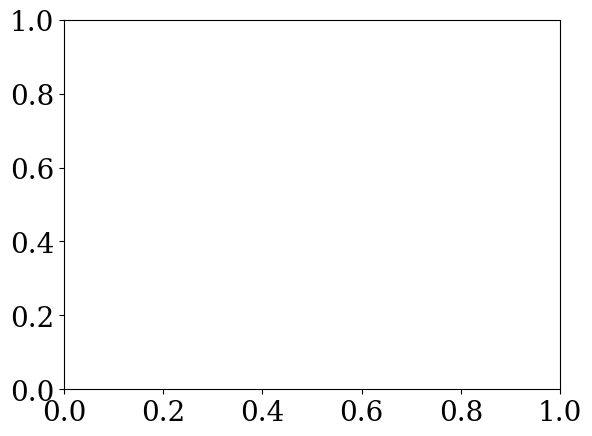

In [36]:
plt.contourf(pressure)

TypeError: Invalid shape (100, 1, 50) for image data

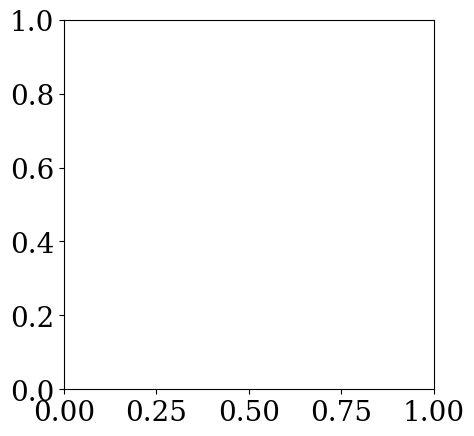

In [32]:
from plots import plot_domain
base = dir_name

## Plot results
## three subplots
fig, ax = plt.subplots(1)

ax.imshow(pressure)  #,extent=[0,100,0,1])
ax.set_title("Domain Cross Section, frame {}".format(icount))

In [26]:
run = Run.from_definition(f'{dir_name}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
mannings = run.Mannings.Geom.domain.Value

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

TypeError: unsupported operand type(s) for +=: 'float' and 'NoneType'

In [ ]:
print(data.shape[1])

In [ ]:
data.shape[0]

In [14]:
data.dz

NameError: name 'data' is not defined

In [17]:
pressure.size

5000

TypeError: Input z must be 2D, not 3D

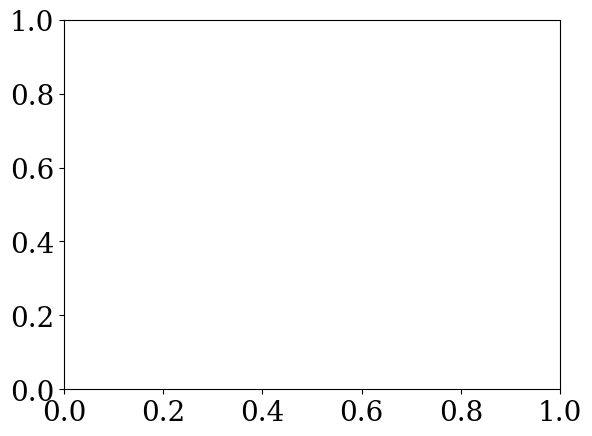

In [20]:
import matplotlib.pyplot as plt
im(pressure[:])

In [25]:
from glob import glob
import parflow as pf

# formatting the mask so that values outside the domain are NA and inside the domain are 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'

#list all pressure files from outputs
lw_press_files = glob(f'{dir_name}/*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{dir_name}/*out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

NameError: name 'mask' is not defined